In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, roc_curve
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
plt.rcParams.update({
    'text.usetex':False,
    'font.family':'monospace'
})  
import seaborn as sns

import optuna
from xgboost import XGBClassifier

In [2]:
def bootstrap_auc_ci(y_true, y_scores, n_bootstraps=2000, ci=0.95):
    rng = np.random.default_rng(42)
    aucs = []

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    for _ in range(n_bootstraps):
        idx = rng.integers(0, len(y_true), len(y_true))
        if len(np.unique(y_true[idx])) < 2:
            continue
        aucs.append(roc_auc_score(y_true[idx], y_scores[idx]))

    lower = np.percentile(aucs, (1 - ci) / 2 * 100)
    upper = np.percentile(aucs, (1 + ci) / 2 * 100)
    return np.mean(aucs), lower, upper

Loading the dataset, pre-processing, and analysing the data

In [3]:
cohort_data = pd.read_csv('../cohort_data_new.csv')
cohort_data

,icustay_id,anion_gap_mean,anion_gap_sd,anion_gap_min,anion_gap_max,bicarbonate_mean,bicarbonate_sd,bicarbonate_min,bicarbonate_max,calcium_total_mean,...,urea_nitrogen_min,urea_nitrogen_max,white_blood_cells_mean,white_blood_cells_sd,white_blood_cells_min,white_blood_cells_max,age,gender,icu_los_hours,target
0,200003,13.375000,3.583195,9.0,21.0,25.250000,3.105295,18.0,28.0,7.771429,...,10.0,21.0,26.471429,13.176711,13.2,43.9,48,M,141,0
1,200007,15.500000,2.121320,14.0,17.0,23.000000,1.414214,22.0,24.0,8.900000,...,8.0,10.0,10.300000,1.272792,9.4,11.2,44,M,30,0
2,200009,9.500000,2.121320,8.0,11.0,23.333333,2.081666,21.0,25.0,8.000000,...,15.0,21.0,12.471429,1.471637,10.5,14.3,47,F,51,0
3,200012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.900000,NaN,4.9,4.9,33,F,10,0
4,200014,10.000000,1.732051,9.0,12.0,24.000000,1.000000,23.0,25.0,7.733333,...,21.0,24.0,13.233333,2.203028,10.7,14.7,85,M,41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30484,299992,15.375000,2.856153,11.0,25.0,23.125000,2.609556,15.0,26.0,8.307143,...,8.0,23.0,14.134783,3.781727,8.1,22.1,41,M,499,0
30485,299993,9.400000,1.341641,8.0,11.0,29.600000,2.073644,26.0,31.0,8.000000,...,12.0,15.0,12.600000,0.605530,12.0,13.3,26,M,67,0
30486,299994,16.157895,2.477973,13.0,24.0,21.631579,3.451417,17.0,31.0,8.100000,...,28.0,63.0,10.076190,2.642329,5.3,14.5,74,F,152,1
30487,299998,11.500000,1.732051,10.0,14.0,23.500000,1.290994,22.0,25.0,8.800000,...,20.0,22.0,9.900000,1.210372,7.9,11.0,87,M,46,1


In [4]:
lab_cols = [
    'anion_gap_mean', 'anion_gap_min', 'anion_gap_max', 'anion_gap_sd',
    'bicarbonate_mean', 'bicarbonate_min', 'bicarbonate_max', 'bicarbonate_sd',
    'calcium_total_mean', 'calcium_total_min', 'calcium_total_max', 'calcium_total_sd',
    'chloride_mean', 'chloride_min', 'chloride_max', 'chloride_sd',
    'creatinine_mean', 'creatinine_min', 'creatinine_max', 'creatinine_sd',
    'glucose_mean', 'glucose_min', 'glucose_max', 'glucose_sd',
    'hematocrit_mean', 'hematocrit_min', 'hematocrit_max', 'hematocrit_sd',
    'hemoglobin_mean', 'hemoglobin_min', 'hemoglobin_max', 'hemoglobin_sd',
    'mchc_mean', 'mchc_min', 'mchc_max', 'mchc_sd',
    'mcv_mean', 'mcv_min', 'mcv_max', 'mcv_sd',
    'magnesium_mean', 'magnesium_min', 'magnesium_max', 'magnesium_sd',
    'pt_mean', 'pt_min', 'pt_max', 'pt_sd',
    'phosphate_mean', 'phosphate_min', 'phosphate_max', 'phosphate_sd',
    'platelet_count_mean', 'platelet_count_min', 'platelet_count_max', 'platelet_count_sd',
    'potassium_mean', 'potassium_min', 'potassium_max', 'potassium_sd',
    'rdw_mean', 'rdw_min', 'rdw_max', 'rdw_sd',
    'red_blood_cells_mean', 'red_blood_cells_min', 'red_blood_cells_max', 'red_blood_cells_sd',
    'sodium_mean', 'sodium_min', 'sodium_max', 'sodium_sd',
    'urea_nitrogen_mean', 'urea_nitrogen_min', 'urea_nitrogen_max', 'urea_nitrogen_sd',
    'white_blood_cells_mean', 'white_blood_cells_min', 'white_blood_cells_max', 'white_blood_cells_sd',
    'age', 'icu_los_hours'
]

In [5]:
# REmove the ICUstay_id and the gender
drop_cols = [c for c in cohort_data.columns if 'icustay_id' in c.lower() or 'gender' in c.lower()]
df = cohort_data.drop(columns=['icustay_id', 'gender'], errors='ignore')

X = df.drop(columns=['target'])
y = df['target']
imputer = SimpleImputer(strategy="median")
df[lab_cols] = imputer.fit_transform(df[lab_cols])

# Keep only numeric
X = X.select_dtypes(include=['number']).replace([np.inf, -np.inf], np.nan)

print(f"Final feature matrix shape: {X.shape}")

Final feature matrix shape: (30489, 90)


In [6]:
# Test-Train split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y, shuffle=True)
print(np.shape(X_train_full))
print(np.shape(X_test))
print(np.shape(y_train_full))
print(np.shape(y_test))

print(f'# Readmissions in Train: {np.sum(y_train_full)}')
print(f'# Readmissions in Test: {np.sum(y_test) }')
print(f'% Readmissions in Train: {np.mean(y_train_full) * 100}')
print(f'% Readmissions in Test: {np.mean(y_test) * 100}')
print(f'Total: {np.sum(y), np.mean(y)*100}')

(21342, 90)
(9147, 90)
(21342,)
(9147,)
# Readmissions in Train: 2293
# Readmissions in Test: 983
% Readmissions in Train: 10.744072720457314
% Readmissions in Test: 10.746692904777523
Total: (np.int64(3276), np.float64(10.74485880153498))


In [7]:
def objective(trial):
    # Train-Dev split for 
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, stratify=y_train_full, random_state=7)

    # Handle imbalance
    scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

    params = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 15),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 2.0),
        "n_estimators": trial.suggest_int("n_estimators", 300, 5000),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
        "scale_pos_weight": scale_pos_weight,
        "random_state": 7,
        "eval_metric": "auc",
        "tree_method": "hist",
        "use_label_encoder": False
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)

    return auc

Hyperparameters

In [8]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25, show_progress_bar=True)

print("Search for hyperparameters complete:")
print(study.best_params)

[I 2025-11-30 21:38:31,113] A new study created in memory with name: no-name-30e40a0f-be7a-478b-a2fb-be875cecd1e8


  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:38:31] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:38:35,981] Trial 0 finished with value: 0.6507477263016541 and parameters: {'learning_rate': 0.2707998004929366, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.331954949721044, 'subsample': 0.48142805826839163, 'colsample_bytree': 0.6807029422337452, 'reg_alpha': 0.3713616022046022, 'reg_lambda': 0.03341153851252046, 'n_estimators': 396, 'max_delta_step': 10}. Best is trial 0 with value: 0.6507477263016541.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:38:36] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:38:46,158] Trial 1 finished with value: 0.681098801603288 and parameters: {'learning_rate': 0.05604307162498571, 'max_depth': 10, 'min_child_weight': 15, 'gamma': 0.5639019151089788, 'subsample': 0.6148308244304607, 'colsample_bytree': 0.45075206535698265, 'reg_alpha': 0.9866288530910253, 'reg_lambda': 1.2161593943290234, 'n_estimators': 956, 'max_delta_step': 8}. Best is trial 1 with value: 0.681098801603288.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:38:46] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:39:01,916] Trial 2 finished with value: 0.6667137174713627 and parameters: {'learning_rate': 0.15509260960794682, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 0.57805362166672, 'subsample': 0.5001307230164583, 'colsample_bytree': 0.406467200740951, 'reg_alpha': 0.5772587539287001, 'reg_lambda': 1.8322952391874192, 'n_estimators': 2575, 'max_delta_step': 4}. Best is trial 1 with value: 0.681098801603288.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:39:02] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:40:19,946] Trial 3 finished with value: 0.6977603816964739 and parameters: {'learning_rate': 0.00518112084172388, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 0.4072968714676085, 'subsample': 0.6925724005237959, 'colsample_bytree': 0.765406232556137, 'reg_alpha': 0.28496852545310936, 'reg_lambda': 1.1857760682403817, 'n_estimators': 3935, 'max_delta_step': 1}. Best is trial 3 with value: 0.6977603816964739.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:40:20] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:40:42,228] Trial 4 finished with value: 0.6996927709617694 and parameters: {'learning_rate': 0.013307085944362841, 'max_depth': 19, 'min_child_weight': 9, 'gamma': 0.9923044706880323, 'subsample': 0.4917891187833085, 'colsample_bytree': 0.4752705436824615, 'reg_alpha': 0.665406902516122, 'reg_lambda': 0.7515336090541864, 'n_estimators': 763, 'max_delta_step': 0}. Best is trial 4 with value: 0.6996927709617694.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:40:42] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:41:06,549] Trial 5 finished with value: 0.6936504303241166 and parameters: {'learning_rate': 0.0035999308228973825, 'max_depth': 13, 'min_child_weight': 13, 'gamma': 0.5524975236501047, 'subsample': 0.9702876461317906, 'colsample_bytree': 0.5836293907195275, 'reg_alpha': 0.9161370166128587, 'reg_lambda': 1.4851375862623932, 'n_estimators': 468, 'max_delta_step': 9}. Best is trial 4 with value: 0.6996927709617694.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:41:06] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:41:49,178] Trial 6 finished with value: 0.7030444413925004 and parameters: {'learning_rate': 0.00632764181501615, 'max_depth': 15, 'min_child_weight': 14, 'gamma': 0.9639719359115256, 'subsample': 0.5598993520655126, 'colsample_bytree': 0.6624497224546875, 'reg_alpha': 0.2193034850486919, 'reg_lambda': 0.5337007052739331, 'n_estimators': 1722, 'max_delta_step': 1}. Best is trial 6 with value: 0.7030444413925004.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:41:49] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:42:21,269] Trial 7 finished with value: 0.6967196687623349 and parameters: {'learning_rate': 0.011334369003471925, 'max_depth': 12, 'min_child_weight': 12, 'gamma': 0.8976763860656838, 'subsample': 0.7617649455611872, 'colsample_bytree': 0.6777283671556262, 'reg_alpha': 0.3073861361467213, 'reg_lambda': 1.9512669958102702, 'n_estimators': 1622, 'max_delta_step': 8}. Best is trial 6 with value: 0.7030444413925004.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:42:21] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:42:50,251] Trial 8 finished with value: 0.6976983255000101 and parameters: {'learning_rate': 0.0017573599684484766, 'max_depth': 8, 'min_child_weight': 12, 'gamma': 0.8787135523873187, 'subsample': 0.7254606123551298, 'colsample_bytree': 0.9920385824341843, 'reg_alpha': 0.6067803916532997, 'reg_lambda': 0.35322270500905667, 'n_estimators': 1775, 'max_delta_step': 4}. Best is trial 6 with value: 0.7030444413925004.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:42:50] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:42:56,853] Trial 9 finished with value: 0.6911521597590999 and parameters: {'learning_rate': 0.08108122602106628, 'max_depth': 23, 'min_child_weight': 7, 'gamma': 0.5002062042783495, 'subsample': 0.897967262608782, 'colsample_bytree': 0.710596022715127, 'reg_alpha': 0.3869742905610577, 'reg_lambda': 0.5487757903949845, 'n_estimators': 343, 'max_delta_step': 3}. Best is trial 6 with value: 0.7030444413925004.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:42:57] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:43:43,647] Trial 10 finished with value: 0.6994709963580134 and parameters: {'learning_rate': 0.0011208504547983865, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.07626048119964951, 'subsample': 0.41015289190280885, 'colsample_bytree': 0.8941207580717538, 'reg_alpha': 0.0038001862691389166, 'reg_lambda': 0.10822367726634052, 'n_estimators': 4973, 'max_delta_step': 6}. Best is trial 6 with value: 0.7030444413925004.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:43:43] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:44:10,021] Trial 11 finished with value: 0.6895687094345765 and parameters: {'learning_rate': 0.02798279597004843, 'max_depth': 19, 'min_child_weight': 8, 'gamma': 0.9850939196797595, 'subsample': 0.5730255456764726, 'colsample_bytree': 0.541535194534471, 'reg_alpha': 0.7985441540249774, 'reg_lambda': 0.6938087867352596, 'n_estimators': 1768, 'max_delta_step': 0}. Best is trial 6 with value: 0.7030444413925004.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:44:10] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:45:01,976] Trial 12 finished with value: 0.6918132871472461 and parameters: {'learning_rate': 0.01205467929998755, 'max_depth': 18, 'min_child_weight': 5, 'gamma': 0.7778957143658919, 'subsample': 0.5730821256754447, 'colsample_bytree': 0.5498833719266596, 'reg_alpha': 0.0464772570709589, 'reg_lambda': 0.7908367374612586, 'n_estimators': 2718, 'max_delta_step': 2}. Best is trial 6 with value: 0.7030444413925004.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:45:02] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:46:13,410] Trial 13 finished with value: 0.7007810433579523 and parameters: {'learning_rate': 0.0050425055158218055, 'max_depth': 18, 'min_child_weight': 9, 'gamma': 0.7373603664198433, 'subsample': 0.40196423239661727, 'colsample_bytree': 0.8278651974103253, 'reg_alpha': 0.7035419365106975, 'reg_lambda': 0.8616565133768385, 'n_estimators': 2634, 'max_delta_step': 0}. Best is trial 6 with value: 0.7030444413925004.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:46:13] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:47:19,669] Trial 14 finished with value: 0.701707562717451 and parameters: {'learning_rate': 0.00454087358608387, 'max_depth': 25, 'min_child_weight': 15, 'gamma': 0.7200936568500342, 'subsample': 0.4018807947578336, 'colsample_bytree': 0.8128349770304832, 'reg_alpha': 0.16655149488580212, 'reg_lambda': 1.0218057806838812, 'n_estimators': 2975, 'max_delta_step': 2}. Best is trial 6 with value: 0.7030444413925004.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:47:19] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:49:08,401] Trial 15 finished with value: 0.7043523265987102 and parameters: {'learning_rate': 0.0023432644168911846, 'max_depth': 24, 'min_child_weight': 15, 'gamma': 0.7200544443339337, 'subsample': 0.6460100865072119, 'colsample_bytree': 0.8975538679640068, 'reg_alpha': 0.1553115655160151, 'reg_lambda': 1.1436054168441665, 'n_estimators': 3564, 'max_delta_step': 2}. Best is trial 15 with value: 0.7043523265987102.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:49:08] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:50:49,120] Trial 16 finished with value: 0.7031712242365052 and parameters: {'learning_rate': 0.00256510232162966, 'max_depth': 23, 'min_child_weight': 14, 'gamma': 0.8503476536261999, 'subsample': 0.8027774804514771, 'colsample_bytree': 0.9276088320542549, 'reg_alpha': 0.16284747798557506, 'reg_lambda': 1.520797006861378, 'n_estimators': 3430, 'max_delta_step': 6}. Best is trial 15 with value: 0.7043523265987102.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:50:49] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:53:00,990] Trial 17 finished with value: 0.7023905623715639 and parameters: {'learning_rate': 0.002106962571336473, 'max_depth': 22, 'min_child_weight': 10, 'gamma': 0.6754379498078404, 'subsample': 0.8263801649546823, 'colsample_bytree': 0.9958660421943142, 'reg_alpha': 0.11270656761369938, 'reg_lambda': 1.5728262880685713, 'n_estimators': 3771, 'max_delta_step': 6}. Best is trial 15 with value: 0.7043523265987102.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:53:01] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:54:37,189] Trial 18 finished with value: 0.7050092575637347 and parameters: {'learning_rate': 0.0011490734579702366, 'max_depth': 22, 'min_child_weight': 15, 'gamma': 0.8064071769227453, 'subsample': 0.6565415406939027, 'colsample_bytree': 0.9059692720887743, 'reg_alpha': 0.48185760469436184, 'reg_lambda': 1.5042075960312093, 'n_estimators': 3727, 'max_delta_step': 6}. Best is trial 18 with value: 0.7050092575637347.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:54:37] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:57:37,400] Trial 19 finished with value: 0.7031897902297096 and parameters: {'learning_rate': 0.0010313909225947884, 'max_depth': 25, 'min_child_weight': 6, 'gamma': 0.276125289521026, 'subsample': 0.6593888985287631, 'colsample_bytree': 0.900591042139925, 'reg_alpha': 0.5009319217083662, 'reg_lambda': 1.292549629222252, 'n_estimators': 4595, 'max_delta_step': 5}. Best is trial 18 with value: 0.7050092575637347.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:57:37] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 21:58:13,293] Trial 20 finished with value: 0.690707847565566 and parameters: {'learning_rate': 0.026222103425175673, 'max_depth': 21, 'min_child_weight': 10, 'gamma': 0.6607128744615476, 'subsample': 0.6652982975040256, 'colsample_bytree': 0.8374605453238922, 'reg_alpha': 0.45173952955676366, 'reg_lambda': 1.740396628442503, 'n_estimators': 4137, 'max_delta_step': 7}. Best is trial 18 with value: 0.7050092575637347.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:58:13] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 22:01:20,986] Trial 21 finished with value: 0.7018504954322571 and parameters: {'learning_rate': 0.0010236085789032494, 'max_depth': 25, 'min_child_weight': 5, 'gamma': 0.20071416963299138, 'subsample': 0.6458287495035884, 'colsample_bytree': 0.8950705003011753, 'reg_alpha': 0.5354113971629417, 'reg_lambda': 1.2805675918794097, 'n_estimators': 4584, 'max_delta_step': 5}. Best is trial 18 with value: 0.7050092575637347.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:01:21] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 22:03:59,151] Trial 22 finished with value: 0.7040514557773301 and parameters: {'learning_rate': 0.0017277192182553552, 'max_depth': 25, 'min_child_weight': 6, 'gamma': 0.3393738853856892, 'subsample': 0.7436938059842442, 'colsample_bytree': 0.9362589625414128, 'reg_alpha': 0.4279788586646716, 'reg_lambda': 1.3867702202426335, 'n_estimators': 4449, 'max_delta_step': 4}. Best is trial 18 with value: 0.7050092575637347.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:59] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 22:06:33,368] Trial 23 finished with value: 0.703723626116503 and parameters: {'learning_rate': 0.0016624733789291821, 'max_depth': 21, 'min_child_weight': 4, 'gamma': 0.41123885471953964, 'subsample': 0.746810897604129, 'colsample_bytree': 0.9537820907892514, 'reg_alpha': 0.4335970340818085, 'reg_lambda': 1.056843474498391, 'n_estimators': 3413, 'max_delta_step': 3}. Best is trial 18 with value: 0.7050092575637347.


C:\Users\risha\AppData\Local\Temp\ipykernel_11520\2097675867.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:33] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-30 22:09:54,915] Trial 24 finished with value: 0.7018298948096604 and parameters: {'learning_rate': 0.003052938925932561, 'max_depth': 23, 'min_child_weight': 1, 'gamma': 0.02143245491481971, 'subsample': 0.8327443792841338, 'colsample_bytree': 0.7629998054835714, 'reg_alpha': 0.29131250846594947, 'reg_lambda': 1.45907055872383, 'n_estimators': 4330, 'max_delta_step': 4}. Best is trial 18 with value: 0.7050092575637347.
Search for hyperparameters complete:
{'learning_rate': 0.0011490734579702366, 'max_depth': 22, 'min_child_weight': 15, 'gamma': 0.8064071769227453, 'subsample': 0.6565415406939027, 'colsample_bytree': 0.9059692720887743, 'reg_alpha': 0.48185760469436184, 'reg_lambda': 1.5042075960312093, 'n_estimators': 3727, 'max_delta_step': 6}


In [9]:
# using the best hyperparams for final training on complete training set
best_params = study.best_params
best_params.update({
    "random_state": 7,
    "eval_metric": "auc",
    "tree_method": "hist",
    "use_label_encoder": False,
    "scale_pos_weight": (y_train_full.value_counts()[0] / y_train_full.value_counts()[1])
})

final_model = XGBClassifier(**best_params)
final_model.fit(X_train_full, y_train_full)

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:09:55] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9059692720887743, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=0.8064071769227453, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0011490734579702366,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=6, max_depth=22, max_leaves=None,
              min_child_weight=15, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3727, n_jobs=None,
              num_parallel_tree=None, ...)

Evaluate

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      8164
           1       0.37      0.23      0.28       983

    accuracy                           0.88      9147
   macro avg       0.64      0.59      0.61      9147
weighted avg       0.85      0.88      0.86      9147

ROC-AUC: 0.7453
95% CI = [0.7296, 0.7607]


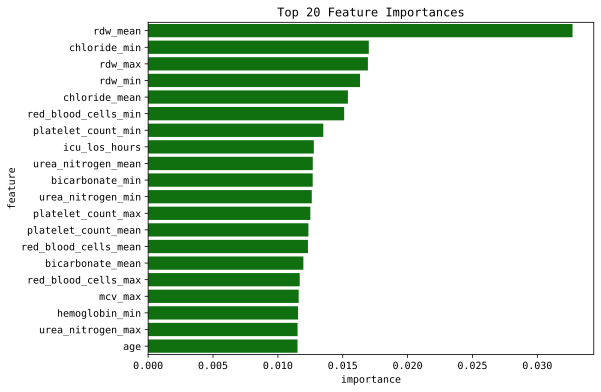

In [10]:
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
auprc = average_precision_score(y_test, y_proba)

np.savez(f'../results/xgboost_imputed_fpr_tpr_thresholds.npz', fpr, tpr, thresholds)
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc:.4f}")
_, lower, upper = bootstrap_auc_ci(y_test, y_proba)
print(f"95% CI = [{lower:.4f}, {upper:.4f}]")

importances = final_model.feature_importances_
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(y='feature', x='importance', data=feat_imp, color='green')
plt.title("Top 20 Feature Importances")
plt.show()